In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 49.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5fbe1225df9d4fa6106eddb20576fc436d1011793911b16204e2dfe44c4a0c66
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
pdf = pd.read_excel('SAMPLE_SUPERSTORE.xlsx')
df = spark.createDataFrame(pdf)

In [ ]:
df.show()

+-------+--------------------+-------------------+-------------------+--------------+------------+----------------+-----------+-----------+-------------+---------------+-------------+---------------+------------+-----------+---------------+------------+--------------------+------------------+--------+--------+------------------+-------------+--------------+
| Row_ID|            Order_ID|         Order_Date|          Ship_Date|     Ship_Mode| Customer_ID|   Customer_Name|    Segment|Postal_Code|         City|          State|      Country|         Region|      Market| Product_ID|       Category|Sub-Category|        Product_Name|             Sales|Quantity|Discount|            Profit|Shipping_Cost|Order_Priority|
+-------+--------------------+-------------------+-------------------+--------------+------------+----------------+-----------+-----------+-------------+---------------+-------------+---------------+------------+-----------+---------------+------------+--------------------+------

Total 3 countries having maximum sale

In [ ]:
df.groupby('Country').agg({'Sales': 'sum'}).sort("sum(Sales)",ascending=False).show(3)

+-------------+------------------+
|      Country|        sum(Sales)|
+-------------+------------------+
|United States|2297200.8602999537|
|    Australia| 925235.8529999999|
|       France| 858931.0829999994|
+-------------+------------------+
only showing top 3 rows



Number of Products on different order priority

In [ ]:
df.groupBy("Order_Priority").count().sort("count",ascending=False).show()

+--------------+-----+
|Order_Priority|count|
+--------------+-----+
|        Medium|29433|
|          High|15501|
|      Critical| 3932|
|           Low| 2424|
+--------------+-----+



Average shipping cost of different ship modes.

In [ ]:
df.groupby('Ship_Mode').agg({'Shipping_Cost': 'avg'}).sort("avg(Shipping_Cost)",ascending=False).show()

+--------------+------------------+
|     Ship_Mode|avg(Shipping_Cost)|
+--------------+------------------+
|      Same Day| 42.99915438726389|
|   First Class| 41.11732732045308|
|  Second Class| 30.55677469783682|
|Standard Class|20.092596441917028|
+--------------+------------------+



Percentage of ordered products with discount and without discount.

In [ ]:
from pyspark.sql.functions import when, lit, col
from pyspark.sql.window import Window
import pyspark.sql.functions as f
df1 = df.select('Discount')
df2 = df1.withColumn("Ordered_Products", when(col("Discount") == 0,lit("No_Discount_available")).otherwise(lit("Discount_available")))
df3 = df2.groupby("Ordered_Products").count()
per = df3.withColumn('Percentage',f.col('count')/f.sum('count').over(Window.partitionBy())*100)
per.show(truncate=False)


+---------------------+-----+------------------+
|Ordered_Products     |count|Percentage        |
+---------------------+-----+------------------+
|No_Discount_available|29009|56.558783388574774|
|Discount_available   |22281|43.44121661142523 |
+---------------------+-----+------------------+



Top 5 cities having maximum profit

In [ ]:
df.groupby('City').agg({'Profit': 'sum'}).sort("sum(Profit)",ascending=False).show(5)

+-------------+------------------+
|         City|       sum(Profit)|
+-------------+------------------+
|New York City|62036.983699999975|
|  Los Angeles| 30440.75789999999|
|      Seattle|29156.096699999984|
|      Managua|17853.718039999996|
|San Francisco|17507.385399999977|
+-------------+------------------+
only showing top 5 rows



Number of days in between order date and shipping date of the product.

In [ ]:
from pyspark.sql.functions import *
df1=df.select('Order_ID','Order_Date','Ship_Date')
df2=df1.withColumn('DiffInHours',(unix_timestamp("Ship_Date") - unix_timestamp('Order_Date'))/3600) \
    .withColumn("DiffInDays",round(col("DiffInHours")/24)) \
    .sort("DiffInDays",ascending=False)
df2.show(truncate=False)

df3=df2.select('DiffInDays')
df3.groupby('DiffInDays').count().show()

+------------------------+-------------------+-------------------+-----------+----------+
|Order_ID                |Order_Date         |Ship_Date          |DiffInHours|DiffInDays|
+------------------------+-------------------+-------------------+-----------+----------+
|IR-2013-KN670560-41508  |2013-08-22 00:00:00|2013-08-29 00:00:00|168.0      |7.0       |
|MX-2014-SS2014018-41658 |2014-01-19 00:00:00|2014-01-26 00:00:00|168.0      |7.0       |
|IN-2013-KN163907-41611  |2013-12-03 00:00:00|2013-12-10 00:00:00|168.0      |7.0       |
|CA-2015-AB10060140-42315|2015-11-07 00:00:00|2015-11-14 00:00:00|168.0      |7.0       |
|ID-2012-BM115757-41149  |2012-08-28 00:00:00|2012-09-04 00:00:00|168.0      |7.0       |
|CA-2015-AB10060140-42315|2015-11-07 00:00:00|2015-11-14 00:00:00|168.0      |7.0       |
|IN-2012-AG1049527-41248 |2012-12-05 00:00:00|2012-12-12 00:00:00|168.0      |7.0       |
|CA-2012-AS10090140-41173|2012-09-21 00:00:00|2012-09-28 00:00:00|168.0      |7.0       |
|ES-2015-H

Number of Orders in each month and year

+--------------------+-------------------+--------------+---------------+
|            Order_ID|         Order_Date|yearly_ordered|monthly_ordered|
+--------------------+-------------------+--------------+---------------+
|CA-2014-AB1001514...|2014-11-11 00:00:00|          2014|            Nov|
|IN-2014-JR162107-...|2014-02-05 00:00:00|          2014|            Feb|
|IN-2014-CR127307-...|2014-10-17 00:00:00|          2014|            Oct|
|ES-2014-KM1637548...|2014-01-28 00:00:00|          2014|            Jan|
|SG-2014-RH9495111...|2014-11-05 00:00:00|          2014|            Nov|
|IN-2014-JM156557-...|2014-06-28 00:00:00|          2014|            Jun|
|IN-2012-TS2134092...|2012-11-06 00:00:00|          2012|            Nov|
|IN-2013-MB1808592...|2013-04-14 00:00:00|          2013|            Apr|
|CA-2014-AB1001514...|2014-11-11 00:00:00|          2014|            Nov|
|CA-2012-AB1001514...|2012-03-06 00:00:00|          2012|            Mar|
|CA-2012-AB1001514...|2012-03-06 00:00

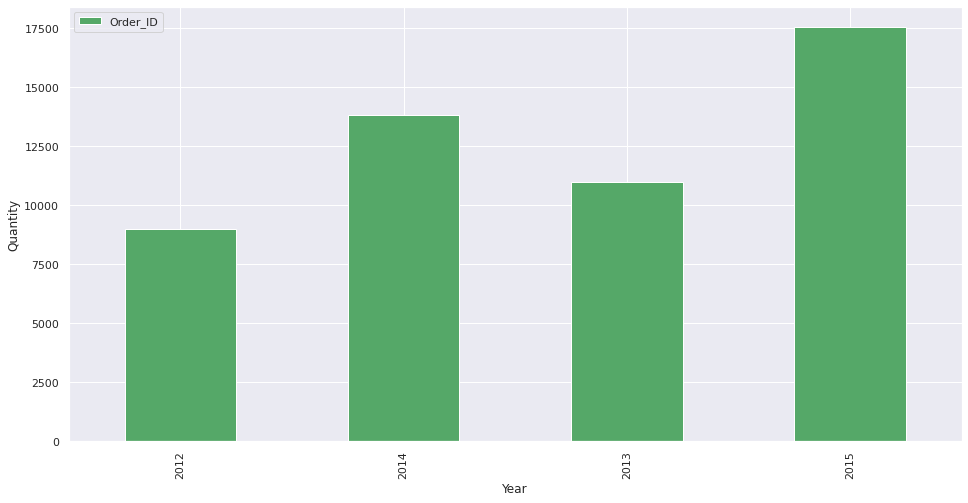

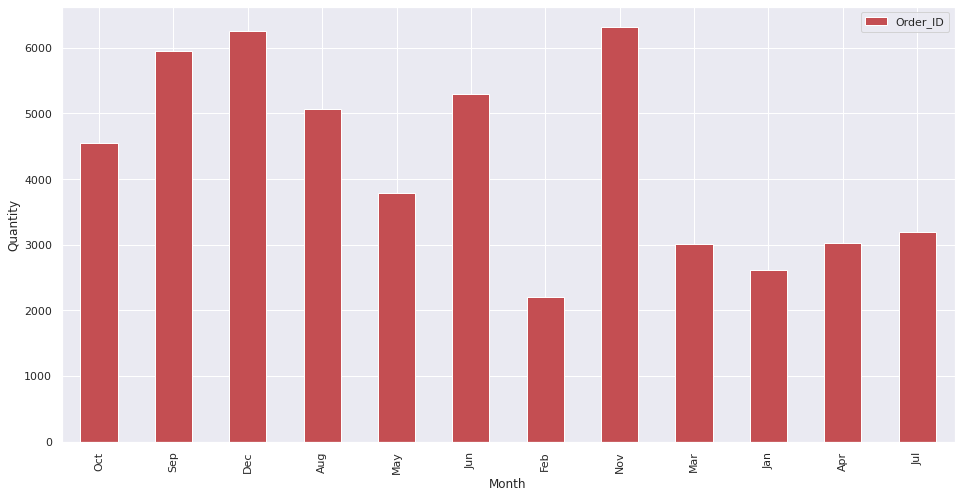

In [ ]:
import pyspark.sql.functions as funcs
%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 8)}

df1=df.select('Order_ID','Order_Date')
df2=df1.withColumn('yearly_ordered', funcs.date_format(df1['Order_Date'], 'yyyy')) \
       .withColumn('monthly_ordered', funcs.date_format(df1['Order_Date'], 'MMM'))
df2.show()

(df2.groupby('yearly_ordered')
 .agg(
     funcs.count(funcs.col('Order_ID')).alias('Order_ID')
 ).toPandas().plot(kind='bar',color = ['g'], x='yearly_ordered', xlabel="Year", ylabel='Quantity')
)

(df2.groupby('monthly_ordered')
 .agg(
     funcs.count(funcs.col('Order_ID')).alias('Order_ID')
 ).toPandas().plot(kind='bar',color = ['r'], x='monthly_ordered', xlabel="Month", ylabel='Quantity')
)

df3 = df2.select('yearly_ordered')
df3.groupby('yearly_ordered').count().show()

df4 = df2.select('monthly_ordered')
df4.groupby('monthly_ordered').count().show()

Top 5 regions having maximum sales.

In [ ]:
df1=df.select('Region','Sales')
df2 = df1.groupby('Region').sum('Sales').sort('sum(Sales)', ascending=False)
df2.show(5)


+-----------------+------------------+
|           Region|        sum(Sales)|
+-----------------+------------------+
|   Western Europe|1731929.6684999957|
|  Central America|1223100.6281600003|
|          Oceania|1100184.6119999948|
|Southeastern Asia| 884423.1690000044|
|    Southern Asia| 866572.6769999947|
+-----------------+------------------+
only showing top 5 rows



Top 5 markets having maximum profit.

In [ ]:
df1=df.select('Market','Profit')
df2 = df1.groupby('Market').sum('Profit').sort('sum(Profit)', ascending=False)
df2.show(5)

+------------+------------------+
|      Market|       sum(Profit)|
+------------+------------------+
|      Europe|449551.72349999903|
|Asia Pacific|403176.03800000204|
|        USCA| 304214.4116999998|
|       LATAM|221643.48708000052|
|      Africa| 88871.63099999998|
+------------+------------------+



Display those tech products along with their product id which ain't giving any discount to customers.

In [ ]:
df.select("Product_Name","Product_ID").where(df.Discount<0.1).show()

+--------------------+-----------+
|        Product_Name| Product_ID|
+--------------------+-----------+
|    Samsung Convoy 3|TEC-PH-5816|
|Sharp Wireless Fa...|TEC-CO-6011|
|Novimex Executive...|FUR-CH-5378|
|Chromcraft Confer...|FUR-TA-3764|
|Sauder Facets Col...|FUR-BO-5957|
|          Newell 330|OFF-AR-5309|
|Bevis Conference ...|FUR-TA-3420|
|Cisco Smart Phone...|TEC-PH-3807|
|Harbour Creations...|FUR-CH-4530|
|KitchenAid Microw...|OFF-AP-4959|
|   Hoover Stove, Red|OFF-AP-4743|
|KitchenAid Stove,...|OFF-AP-4967|
|Hon Computer Tabl...|FUR-TA-4644|
|Carina 42"Hx23 3/...|OFF-ST-3744|
|SAFCO Executive L...|FUR-CH-5774|
|KitchenAid Refrig...|OFF-AP-4960|
|Motorola Smart Ph...|TEC-PH-5268|
|Lesro Conference ...|FUR-TA-5060|
|             Staples|OFF-FA-6129|
|Office Star Execu...|FUR-CH-5443|
+--------------------+-----------+
only showing top 20 rows



Display all those products along with their product id and category, which are always in loss.



In [ ]:
df.select("Product_Name","Category","Product_ID").where(df.Profit<0).show()

+--------------------+---------------+-----------+
|        Product_Name|       Category| Product_ID|
+--------------------+---------------+-----------+
|Novimex Executive...|      Furniture|FUR-CH-5379|
|Motorola Smart Ph...|     Technology|TEC-PH-5267|
|  Akro Stacking Bins|Office Supplies|OFF-ST-3078|
|Samsung Smart Pho...|     Technology|TEC-PH-5841|
|Motorola Smart Ph...|     Technology|TEC-PH-5268|
|Cisco CP-7937G Un...|     Technology|TEC-MA-3788|
|Bevis Conference ...|      Furniture|FUR-TA-3422|
|Bady BDG101FRU Ca...|     Technology|TEC-MA-3329|
|Avery Trapezoid E...|Office Supplies|OFF-BI-3324|
|Hamilton Beach Re...|Office Supplies|OFF-AP-4501|
|Lesro Sheffield C...|      Furniture|FUR-TA-5066|
|Avery Recycled Fl...|Office Supplies|OFF-BI-3308|
|Panasonic Printer...|     Technology|TEC-MA-5572|
|Office Star Execu...|      Furniture|FUR-CH-5442|
|Apple Smart Phone...|     Technology|TEC-PH-3149|
|Avery 3 1/2" Disk...|Office Supplies|OFF-BI-3185|
|Canon Wireless Fa...|     Tech

Display all those products along with country, state and city, which were shipped on the same day of ordering.



In [ ]:
df.select("Product_Name", "Country", "State", "City").where(df.Order_Date==df.Ship_Date).show()

+--------------------+-----------+--------------------+--------------------+
|        Product_Name|    Country|               State|                City|
+--------------------+-----------+--------------------+--------------------+
|Harbour Creations...|     Brazil|              Parana|              Toledo|
|Office Star Execu...|      India|             Gujarat|               Surat|
|Office Star Execu...|     France|       Ile-de-France|           Montreuil|
|Konica Inkjet, White|      India|           Jharkhand|          Jamshedpur|
|Motorola Smart Ph...| Mozambique|    Cidade De Maputo|              Maputo|
|Samsung Smart Pho...|     Mexico|             Durango|       Gómez Palacio|
|Novimex Executive...|      India|         West Bengal|             Naihati|
| Hoover Stove, White|    Morocco|    Grand Casablanca|          Casablanca|
|Brother Wireless ...|  Australia|     New South Wales|              Sydney|
|Hamilton Beach St...|     France|       Ile-de-France|               Paris|

Display the count of postal codes which are unavailable.

In [ ]:
df.select("Postal_Code").where(df.Postal_Code=="NaN").count()

41296

Count the number of products with high order priority

In [ ]:
df.select("Order_Priority").where(df.Order_Priority=="High").count()


15501

Display all those customer names along with product who have bought just single piece of product.

In [ ]:
df.select("Customer_Name","Product_Name").where(df.Quantity==1).show()

+------------------+--------------------+
|     Customer_Name|        Product_Name|
+------------------+--------------------+
|     Aaron Bergman|Global Push Butto...|
|   Adam Bellavance|Logitech G600 MMO...|
|   Adam Bellavance|Acco Hanging Data...|
|   Adam Bellavance|Sabrent 4-Port US...|
|   Adam Bellavance|Ampad Gold Fibre ...|
|         Adam Hart|Fellowes File Car...|
|         Adam Hart|Hoover Replacemen...|
|Adam Shillingsburg|Belkin 7-Outlet S...|
|     Clay Cheatham|Lesro Conference ...|
|Adam Shillingsburg|Cardinal Holdit B...|
|       Peter McVee|Motorola Smart Ph...|
|       Anna Gayman|Hon Conference Ta...|
|     Adrian Barton|           Avery 487|
|      Adrian Shami|Eldon Image Serie...|
|       Aimee Bixby|Acme Elite Stainl...|
|       Alan Barnes|Imation Bio 8GB U...|
|    Alan Dominguez|1/4 Fold Party De...|
|   Alejandro Grove|Hon Executive Lea...|
|       Alan Haines|Acco Translucent ...|
| Alan Schoenberger|Belkin 8-Outlet P...|
+------------------+--------------

Drop all the rows with null values

In [ ]:
df1 = df.na.drop().show()

+-------+--------------------+-------------------+-------------------+--------------+------------+--------------+---------+-----------+-------------+--------------+-------------+-----------+------+-----------+---------------+------------+--------------------+------------------+--------+--------+-------------------+-------------+--------------+
| Row_ID|            Order_ID|         Order_Date|          Ship_Date|     Ship_Mode| Customer_ID| Customer_Name|  Segment|Postal_Code|         City|         State|      Country|     Region|Market| Product_ID|       Category|Sub-Category|        Product_Name|             Sales|Quantity|Discount|             Profit|Shipping_Cost|Order_Priority|
+-------+--------------------+-------------------+-------------------+--------------+------------+--------------+---------+-----------+-------------+--------------+-------------+-----------+------+-----------+---------------+------------+--------------------+------------------+--------+--------+------------

Display the category with highest sales

In [ ]:
df.agg({"Sales":"max","Category" : "max"}).show()

+----------+-------------+
|max(Sales)|max(Category)|
+----------+-------------+
|  22638.48|   Technology|
+----------+-------------+



Display the minimum sales of each product along with country.

In [ ]:
df.groupby('Product_Name','Country').agg({'Sales': 'min'}).show()


+--------------------+-------------+------------------+
|        Product_Name|      Country|        min(Sales)|
+--------------------+-------------+------------------+
|KitchenAid Stove,...|    Australia| 4624.290000000001|
|Hamilton Beach St...|    Nicaragua|            1805.9|
|Lesro Conference ...|    Australia|2993.0249999999996|
|Cisco Signal Boos...|        China|151.92000000000002|
|HP Fax Machine, L...|        Italy|            599.88|
|Acco Binder Cover...|       Canada|             54.72|
|Hewlett Fax and C...|      Germany|           1347.57|
|Bretford CR8500 S...|United States|           481.176|
|Ikea Library with...|     Pakistan|2042.5440000000003|
|Smead Lockers, In...|    Australia|            895.05|
|Heavy-Duty E-Z-D ...|United States|2.1819999999999995|
|Eldon Wave Desk A...|United States|              4.16|
|Canon Wireless Fa...|      Belarus|             756.6|
|Brites Rubber Ban...|United States|             3.168|
|Sauder Floating S...|      Germany|          10

Display the product name with highest discount.

In [ ]:
df.agg({"Discount":"max","Product_Name" : "max"}).show()

+-------------+--------------------+
|max(Discount)|   max(Product_Name)|
+-------------+--------------------+
|         0.85|netTALK DUO VoIP ...|
+-------------+--------------------+

